In [4]:
import traffic
import pandas as pd 
from traffic.core import Traffic
from biblio_herramienta.herramienta import *
from biblio_herramienta.tratardatos import *

In [5]:
carpetaDatos = r'datos_sectores/' # carpeta que contiene los datos
nombreDatos = "datos_filtrados.csv" 
vuelos = cargardatosfiltrados(carpetaDatos,nombreDatos)
vuelos

count
icao24 callsign       
4ca60f IBK5BV     3683
4cace5 IBK6054    2974
       IBK6055    2343
49514c TAP434M    2175
344495 GES381L    2052
4cacc6 RYR3PE     2036
4853d1 TRA6845    1926
4cabae RYR4Z      1886
3c56f7 EWG4TP     1814
4ca8da RYR6BM     1805

In [10]:
from traffic.data.samples import switzerland
switzerland.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,track,vertical_rate
0,2018-08-01 05:27:30+00:00,34975.0,DLH8JW,443.486933,3003ae,45.818985,9.229546,324.267082,960.0
1,2018-08-01 05:27:40+00:00,35100.0,DLH8JW,442.903670,3003ae,45.832306,9.227645,324.372093,1024.0
2,2018-08-01 05:27:50+00:00,35275.0,DLH8JW,441.508395,3003ae,45.848740,9.210763,324.401979,960.0
3,2018-08-01 05:28:00+00:00,35425.0,DLH8JW,441.508395,3003ae,45.865779,9.193291,324.401979,832.0
4,2018-08-01 05:28:10+00:00,35550.0,DLH8JW,440.695660,3003ae,45.881927,9.176733,324.326300,832.0


In [11]:
switzerland.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139098 entries, 0 to 139097
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   timestamp      139098 non-null  datetime64[ns, UTC]
 1   altitude       139098 non-null  float64            
 2   callsign       139098 non-null  object             
 3   groundspeed    139098 non-null  float64            
 4   icao24         139098 non-null  object             
 5   latitude       139098 non-null  float64            
 6   longitude      139098 non-null  float64            
 7   track          139098 non-null  float64            
 8   vertical_rate  139098 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), object(2)
memory usage: 9.6+ MB


## Cluster
Se va a intentar clasificar las trayectorias en función de su rumbo. Para eso se va utilziar el método enseñado en traffic

In [12]:
vuelos_un = vuelos.assign_id().unwrap().eval(max_workers=4)
vuelos_un.data.head()

,altitude,callsign,groundspeed,icao24,latitude,longitude,timestamp,track,flight_id,track_unwrapped
0,39000.0,RAM801F,473.0,0200ae,44.375595,-3.977989,2019-02-07 18:13:58+00:00,188.387032,RAM801F_029,188.387032
1,39000.0,RAM801F,473.0,0200ae,44.373453,-3.978391,2019-02-07 18:13:59+00:00,188.387032,RAM801F_029,188.387032
2,39000.0,RAM801F,473.0,0200ae,44.371265,-3.978860,2019-02-07 18:14:00+00:00,188.387032,RAM801F_029,188.387032
3,39000.0,RAM801F,473.0,0200ae,44.368881,-3.979340,2019-02-07 18:14:01+00:00,188.387032,RAM801F_029,188.387032
4,39000.0,RAM801F,473.0,0200ae,44.366730,-3.979797,2019-02-07 18:14:02+00:00,188.387032,RAM801F_029,188.387032


In [13]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from traffic.core.projection import CH1903

vuelos_dbscan = vuelos_un.clustering(
    nb_samples=15,
    features=["longitude", "latitude", "track_unwrapped"],
    clustering=DBSCAN(eps=0.5, min_samples=10),
    transform=StandardScaler(),
).fit_predict()

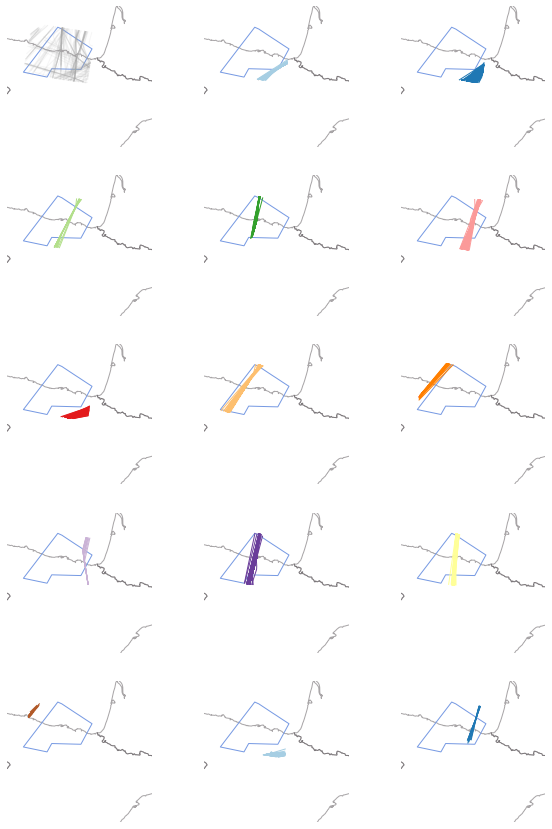

In [27]:
from itertools import islice, cycle
from traffic.drawing import countries, EuroPP
from traffic.data import nm_airspaces

n_clusters = 1 + vuelos_dbscan.data.cluster.max()

# -- dealing with colours --

color_cycle = cycle(
    "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c "
    "#fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
)
colors = list(islice(color_cycle, n_clusters))
colors.append("#aaaaaa")  # color for outliers, if any

# -- dealing with the grid --

nb_cols = 3
nb_lines = (1 + n_clusters) // nb_cols + (((1 + n_clusters) % nb_cols) > 0)

with plt.style.context("traffic"):

    fig, ax = plt.subplots(
        nb_lines, nb_cols, figsize=(10, 15), subplot_kw=dict(projection=EuroPP())
    )
    
    for cluster in range(-1, n_clusters):
        ax_ = ax[(cluster + 1) // nb_cols][(cluster + 1) % nb_cols]
        ax_.add_feature(countries())
        nm_airspaces['LECMBLU'].plot(ax_,alpha = 1)
        
        

        vuelos_dbscan.query(f"cluster == {cluster}").plot(
            ax_, color=colors[cluster], alpha=0.1 if cluster == -1 else 1
        )
        ax_.set_global()
        ax_.set_extent((-6, 1, 40, 45))
        